In [1]:
! pwd

/home/guillermo.carrilho/PhysicsSimulationDeepLearning


In [1]:
import os
import sys


ROOT="/home/guillermo.carrilho/PhysicsSimulationDeepLearning"

sys.path.append(os.path.join(ROOT,"Physical_models"))

In [46]:
#mesh = geom.build_mesh(Box(x=1, y=1), x=100, y=100)
#CenteredGrid(0, 0, x=32, y=32, bounds=Box(x=1, y=1)).geometry

#resolution = math.linspace(0, 1, spatial(y=31))
#Box(resolution)
#Box?
UniformGrid(x=64, y=64,bounds=Box(x=1, y=1))

(xˢ=64, yˢ=64), bounds=Box(x=(0, 1), y=(0, 1))

In [575]:
#from Differentiable_simulation import two_phase_flow,dK_w,K_w,K_o
from phi.torch.flow import *


geo_w=UniformGrid(x=64, y=64,bounds=Box(x=5e3, y=5e3))
phi_w=Field( geo_w,values=tensor(0.0),
      boundary= {
          'x-':3e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

geo_o=UniformGrid(x=64, y=64,bounds=Box(x=5e3, y=5e3))
phi_o=Field( geo_o,values=tensor(0.0),
      boundary= {
          'x-': ZERO_GRADIENT,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

phy=two_phase_flow(
    phi_w,
    phi_o,
    dt=0.01,
    w_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v),
    o_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v)
    #advection_solver=lambda v: Solve('CG-adaptive',1e-3,1e-3,x0=v)
)

In [574]:
from Differentiable_simulation import K_w_f_t,K_o_f_t,dsdpc,dsK_w_f_t,dsK_o_f_t,grad_phi_dK
SWR=0.3
SOR=0.1
KRW=0.05
KRO=0.7
NW=2.0
NO=3.5
MUW=1.0
MUO=1.0
PD=2*(1e3) # Pa
LAMBDA=1

#S_w=(lambda p_c:math.clip(SWR+(1-SWR)*(p_c/PD)**(-1*LAMBDA),1.0,0.0)) # add conditions for p_c=0

#dsdpc=(lambda p_c:(((SWR-1)*LAMBDA)/PD)*((math.clip(p_c,PD))/(PD))**(-1*(LAMBDA + 1)))

dsdpc=(lambda p_c:math.clip((-1*LAMBDA)*((S_w(p_c)-SWR)/PD),lower_limit=1e-6))

S_w=(lambda p_c:math.clip(SWR+(1-SWR)*(p_c/PD)**(-1*LAMBDA),SWR,(1-SOR))) # add conditions for p_c=0
#S_w=(lambda p_c:SWR+(1-SWR)*(math.clip(p_c,PD)/PD)**(-1*LAMBDA)) # add conditions for p_c=0

K_w=lambda p_c:stack(
    [stack([K_w_f_t(S_w(p_c))/(MUW*dsdpc(p_c)),math.zeros_like(p_c)],batch("k") ),
    stack([math.zeros_like(p_c),K_w_f_t(S_w(p_c))/(MUW*dsdpc(p_c))],batch("k") )],batch("KK"))

K_o=lambda p_c:stack(
    [stack([K_o_f_t(S_w(p_c))/(MUW*dsdpc(p_c)),math.zeros_like(p_c)],batch("k") ),
    stack([math.zeros_like(p_c),K_o_f_t(S_w(p_c))/(MUW*dsdpc(p_c))],batch("k") )],batch("KK"))

dK_w=lambda p_c:stack(
    [stack([dsdpc(p_c)*dsK_w_f_t(S_w(p_c))/(MUW*dsdpc(p_c)),math.zeros_like(p_c)],batch("dk") ),
    stack([math.zeros_like(p_c),dsdpc(p_c)*dsK_w_f_t(S_w(p_c))/(MUW*dsdpc(p_c))],batch("dk") )],batch("dKK"))

dK_o=lambda p_c:stack(
    [stack([dsdpc(p_c)*dsK_o_f_t(S_w(p_c))/(MUW*dsdpc(p_c)),math.zeros_like(p_c)],batch("dk") ),
    stack([math.zeros_like(p_c),dsdpc(p_c)*dsK_o_f_t(S_w(p_c))/(MUW*dsdpc(p_c))],batch("dk") )],batch("dKK"))


class two_phase_flow(object):
  def __init__(self,phi_w,phi_o,dt,w_advection_solver,o_advection_solver):
    #self.v0=v0
    self.phi_w=phi_w
    self.phi_o=phi_o
    self.dt=dt
    self.p=None
    self.w_advection_solver=w_advection_solver
    self.o_advection_solver=o_advection_solver


  def compute_p_c(self,phi_w,phi_o):
    p_c=phi_w.sample(phi_w.geometry) -\
    phi_o.sample(phi_o.geometry)
    return p_c

  def compute_convective_velocity(self,phi_a,phi_b,dK_a):
    p_c=self.compute_p_c(self.phi_w,self.phi_o)
    convective_velocity = grad_phi_dK(phi_a,dK_a(p_c))\
                         - grad_phi_dK(phi_b,dK_a(p_c))

    V=unstack(convective_velocity,"dk")
    convective_velocity=Field(self.phi_o.geometry,values=vec(x=V[0],y=V[1]))
    return convective_velocity

  #def compute_anisotropic_viscosity_effect(self):
    # reformulate differential solver
    
  def phi_w_momentum_eq(self,phi_w,phi_o, dt):
    #grad_phi_w=field.spatial_gradient(self.phi_w,self.phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)
    w_advection_term = dt * advect.semi_lagrangian((phi_o),
                                                    self.compute_convective_velocity(phi_w,phi_o,dK_w),
                                                    dt).sample(phi_w.geometry)
    o_advection_term = dt * advect.semi_lagrangian((phi_w),
                                                    self.compute_convective_velocity(phi_o,phi_w,dK_o),
                                                    dt).sample(phi_w.geometry)
    w_diffusion_term = dt * anisotropic_diffusion.implicit(phi_w,K_w(p_c), dt=dt,correct_skew=False).sample(phi_w.geometry)
    o_diffusion_term = dt * anisotropic_diffusion.implicit(phi_o,K_o(p_c), dt=dt,correct_skew=False).sample(phi_w.geometry)

    return phi_w + phi_w.with_values(w_advection_term + o_advection_term) + phi_w.with_values(w_diffusion_term - o_diffusion_term)
  
  def phi_o_momentum_eq(self,phi_o,phi_w, dt):
    #grad_phi_w=field.spatial_gradient(phi_w,phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)
    w_advection_term = dt * advect.semi_lagrangian((phi_o),
                                                    self.compute_convective_velocity(phi_o,phi_w,dK_w),
                                                    dt).sample(phi_o.geometry)
    o_advection_term = dt * advect.semi_lagrangian((phi_w),
                                                    self.compute_convective_velocity(phi_w,phi_o,dK_o),
                                                    dt).sample(phi_o.geometry)
    w_diffusion_term = dt * anisotropic_diffusion.implicit(phi_w,K_w(p_c), dt=dt,correct_skew=False).sample(phi_o.geometry)
    o_diffusion_term = dt * anisotropic_diffusion.implicit(phi_o,K_o(p_c), dt=dt,correct_skew=False).sample(phi_o.geometry)

    return phi_o + phi_o.with_values(w_advection_term + o_advection_term) + phi_o.with_values(o_diffusion_term - w_diffusion_term)


  def implicit_time_step(self, phi_w,phi_o, dt):
    new_phi_w = math.solve_linear(self.phi_w_momentum_eq, phi_w, self.w_advection_solver(phi_w),phi_o, dt=-dt)
    new_phi_o = math.solve_linear(self.phi_o_momentum_eq, phi_o, self.o_advection_solver(phi_o),phi_w, dt=-dt)
    return new_phi_w,new_phi_o

In [576]:
#from Differentiable_simulation import K_o_f_t,S_w,dK_o,dK_w,dK_o,dsdpc
import anisotropic_diffusion
print(S_w(phy.compute_p_c(phi_w,phi_o)))
print(dsdpc(phy.compute_p_c(phi_w,phi_o)))
print(phy.compute_p_c(phi_w,phi_o))
print(dK_w(phy.compute_p_c(phi_w,phi_o)))
print(K_w(phy.compute_p_c(phi_w,phi_o)))
print(phy.compute_convective_velocity(phi_w,phi_o,dK_w).sample(phi_w.geometry))
print(K_o(phy.compute_p_c(phi_w,phi_o)))
print(dK_o(phy.compute_p_c(phi_w,phi_o)))
print(phy.compute_convective_velocity(phi_w,phi_o,dK_o).sample(phi_o.geometry))

(xˢ=64, yˢ=64) const 0.8999999761581421
(xˢ=64, yˢ=64) const 9.999999974752427e-07
(xˢ=64, yˢ=64) const 0.0
(dKKᵇ=2, dkᵇ=2, xˢ=64, yˢ=64) 0.245 ± 0.245 (0e+00...5e-01)
(KKᵇ=2, kᵇ=2, xˢ=64, yˢ=64) 7.35e+04 ± 7.3e+04 (0e+00...1e+05)
(xˢ=64, yˢ=64, vectorᶜ=x,y) -0.073 ± 0.828 (-9e+00...0e+00)
(KKᵇ=2, kᵇ=2, xˢ=64, yˢ=64) const 0.0 / nan
(dKKᵇ=2, dkᵇ=2, xˢ=64, yˢ=64) const 0.0 / nan
(xˢ=64, yˢ=64, vectorᶜ=x,y) nan ± nan (nan...nan)


In [577]:
phi=(phi_w,phi_o)

In [581]:
for i in range(1):
    phi=phy.implicit_time_step(*phi,1e-5)

NotConverged: Φ-ML CG (PyTorch*) did not converge to rel_tol=1e-05, abs_tol=1e-05 within 1000 iterations. Max residual: nan

(xˢ=64, yˢ=64) -0.774 ± 5.948 (-5e+01...0e+00)


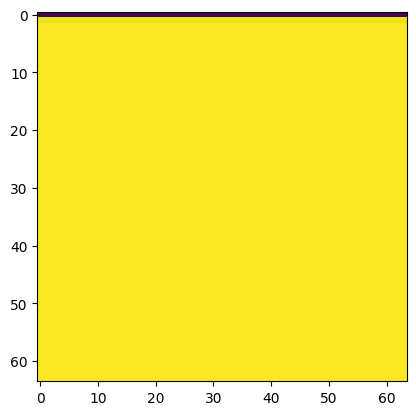

(xˢ=64, yˢ=64) const 0.0


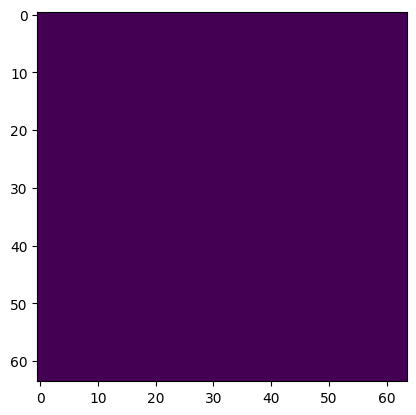

(xˢ=64, yˢ=64) 0.595 ± 0.127 (3e-01...6e-01)


(xˢ=64, yˢ=64) -0.774 ± 5.948 (-5e+01...0e+00)

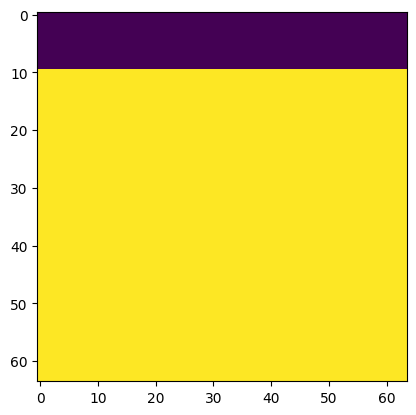

In [ ]:
print(phi[0].sample(geo_w))
plt.imshow(phi[0].sample(geo_w).native("x,y"))
plt.show()
print(phi[1].sample(geo_w))
plt.imshow(phi[1].sample(geo_o).native("x,y"))
plt.show()
plt.imshow(S_w(phy.compute_p_c(*phi)))
print(S_w(phy.compute_p_c(*phi)))

phy.compute_p_c(*phi)

In [568]:
print(S_w(phy.compute_p_c(*phi)).native("x,y"))

tensor([[0.3000, 0.3000, 0.3000,  ..., 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000,  ..., 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000,  ..., 0.3000, 0.3000, 0.3000],
        ...,
        [0.6500, 0.6500, 0.6500,  ..., 0.6500, 0.6500, 0.6500],
        [0.6500, 0.6500, 0.6500,  ..., 0.6500, 0.6500, 0.6500],
        [0.6500, 0.6500, 0.6500,  ..., 0.6500, 0.6500, 0.6500]])


# Gradient Notes

In [ ]:
import torch

### Grandient example

In [ ]:
x1 = torch.ones((3,1,3)).requires_grad_(True)  #
print(x1)

u1 = torch.stack([
    x1[:,:,0]**0.5,
    torch.sin(x1[:,:,1])+x1[:,:,0]**0.5,
    torch.cos(x1[:,:,0]),
    x1[:,:,1]**2,
    ],axis=2)

#u1 = torch.matmul(M,x1)


#u1=torch.sin(torch.matmul(torch.rand(2,2).requires_grad_(True),x1))
print(u1)
print(u1.shape)
torch.autograd.grad(
    u1,x1,
            grad_outputs=torch.ones_like(u1).to(u1.device),
            create_graph=True,
            retain_graph=True,
            allow_unused=True
            )

tensor([[[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]]], requires_grad=True)
tensor([[[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]]], grad_fn=<StackBackward0>)
torch.Size([3, 1, 4])


(tensor([[[0.1585, 2.5403, 0.0000]],
 
         [[0.1585, 2.5403, 0.0000]],
 
         [[0.1585, 2.5403, 0.0000]]], grad_fn=<AddBackward0>),)

### Jacobian computation

Expressed in pytorch with torch.autograd.grad

$$ \textbf{u} \in \mathbb{R}^n \\ \textbf{x},\textbf{e}_i \in \mathbb{R}^m $$
$$ T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i) = \nabla_{\textbf{x}} \textbf{u}_i  $$
$$ T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i) = \nabla_{\textbf{x}} \textbf{u}_i  $$
$$ T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i+\textbf{e}_j) = \nabla_{\textbf{x}} \textbf{u}_i + \nabla_{\textbf{x}} \textbf{u}_j $$
$$ [T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i)]_{i=1}^n = J_{\textbf{x}}(\textbf{u})$$


In [ ]:
unit_vectors=torch.eye(4)
print(u1)
jacobian_rows = [torch.autograd.grad(u1, x1, vec_.unsqueeze(0).unsqueeze(0).tile(u1.shape[0],u1.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
                     for vec_ in unit_vectors]
print(jacobian_rows)
print(torch.stack(jacobian_rows,axis=2))
print(torch.stack(jacobian_rows,axis=2).shape)

torch.autograd.grad(u1, x1, unit_vectors[1].unsqueeze(0).unsqueeze(0).tile(u1.shape[0],u1.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0].shape

tensor([[[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]]], grad_fn=<StackBackward0>)
[tensor([[[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]]], grad_fn=<AddBackward0>), tensor([[[0.5000, 0.5403, 0.0000]],

        [[0.5000, 0.5403, 0.0000]],

        [[0.5000, 0.5403, 0.0000]]], grad_fn=<AddBackward0>), tensor([[[-0.8415,  0.0000,  0.0000]],

        [[-0.8415,  0.0000,  0.0000]],

        [[-0.8415,  0.0000,  0.0000]]], grad_fn=<AddBackward0>), tensor([[[0., 2., 0.]],

        [[0., 2., 0.]],

        [[0., 2., 0.]]], grad_fn=<AddBackward0>)]
tensor([[[[ 0.5000,  0.0000,  0.0000],
          [ 0.5000,  0.5403,  0.0000],
          [-0.8415,  0.0000,  0.0000],
          [ 0.0000,  2.0000,  0.0000]]],


        [[[ 0.5000,  0.0000,  0.0000],
          [ 0.5000,  0.5403,  0.0000],
          [-0.8415,  0.0000,  0.0000],
          [ 0.0000,  2.0000,  0.0000]]],


 

torch.Size([3, 1, 3])

In [ ]:
#

def vector_jacobian(u,x):
    unit_vectors=torch.eye(u.shape[-1])
    jacobian_rows = [torch.autograd.grad(u, x, vec_.unsqueeze(0).unsqueeze(0).tile(u.shape[0],u.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
                     for vec_ in unit_vectors]
    return torch.stack(jacobian_rows,axis=2)


def vector_grad(u,x):
    unit_vectors=torch.eye(u.shape[-1])
    jacobian_rows = [torch.autograd.grad(u, x, vec_.unsqueeze(0).unsqueeze(0).tile(u.shape[0],u.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
                     for vec_ in unit_vectors]
    return torch.diagonal(torch.stack(jacobian_rows,axis=2),dim1=-2,dim2=-1)

def x_grad(u,x,i,n):
    """
    gradient of degree wrt x for componen i for u
    input:
    u and x are tensors with vectors object at dimension -1
    [b, n_vectors, vector_dimension]

    output:
    [b, n_vectors, input_vector_dimension]
    """
    I=torch.eye(u.shape[-1])

    u=torch.autograd.grad(u ,x,
            I[i].unsqueeze(0).unsqueeze(0).tile(u.shape[0],u.shape[1],1).to(u.device),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
    if n > 1:
        for i in range(n-1):
            u=vector_grad(u,x)
    return u

In [ ]:
print(x_grad(u1,x1,0,1))
udx=x_grad(u1,x1,0,1)


tensor([[[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]]], grad_fn=<AddBackward0>)


In [ ]:
print(x1.shape)
x1

torch.Size([3, 1, 3])


tensor([[[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]]], requires_grad=True)

In [ ]:
torch.sum(x1*udx,axis=-1)

tensor([[0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SumBackward1>)

In [ ]:
udx[:,:,:2]

tensor([[[0.5000, 0.0000]],

        [[0.5000, 0.0000]],

        [[0.5000, 0.0000]]], grad_fn=<SliceBackward0>)

# Residuals debug

## NS reesidual

In [ ]:
def incompresibble_fluid_loss(up,xt,mu=1,rho=1):
    l=0
    # x-velocity components
    l+=x_grad(up,xt,0,1)[...,2] # dudt
    l+=torch.sum(up[...,:1]*x_grad(up,xt,0,1)[...,:2],axis=-1) # u * grad u
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,0]) #  dpdx
    l-=(mu/rho)*torch.sum(x_grad(up,xt,0,2)[...,:2],axis=-1) # grad**2 u
    # y-velocity components
    l+=x_grad(up,xt,1,1)[...,2] # dvdt
    l+=torch.sum(up[...,1:2]*x_grad(up,xt,0,1)[...,:2],axis=-1) # v * grad v
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,1]) #  dpdy
    l-=(mu/rho)*torch.sum(x_grad(up,xt,1,2)[...,:2],axis=-1) # grad**2 v
    return l

### Debug

In [ ]:
x1 = torch.randn((3,1,3)).requires_grad_(True)  #
print(x1)
print(x1.shape)

u1 = torch.stack([
    x1[:,:,0]**0.5,
    torch.sin(x1[:,:,1])+x1[:,:,0]**0.5,
    torch.cos(x1[:,:,0]),
    ],axis=2)

print(u1.shape)

tensor([[[-1.5316, -0.0218,  1.3527]],

        [[ 2.0246,  0.5625, -0.8633]],

        [[ 0.5488, -0.9313,  0.3730]]], requires_grad=True)
torch.Size([3, 1, 3])
torch.Size([3, 1, 3])


In [ ]:
incompresibble_fluid_loss(u1,x1,1,1)-0
#x_grad(u1,x1,0,1)[...,0]
#print(x1[:,:,:1])
#print(x_grad(u1,x1,0,1)[...,:2])
#x_grad(u1,x1,0,1)[...,2]
#x_grad(u1,x1,0,2)[...,:2]

tensor([[   nan],
        [0.9955],
        [0.3642]], grad_fn=<SubBackward0>)